# BostonHousing MLP 모델 구현
## 기계학습(02)
#### 20213013 컴퓨터공학과 김어진

## 데이터 로드 및 정규화

In [153]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore


# CSV 파일 로드 
df_data = pd.read_csv('C:\\Users\\chosun\\Downloads\\BostonHousing.csv') 


In [154]:

# 데이터 분할
bh_data = np.array(df_data.values, dtype=np.float32)
X = bh_data[:, :13]
y = bh_data[:, 13].reshape(-1, 1)

# 데이터 분할 (train_test_split 사용)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일러 초기화
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# 데이터 정규화
x_train = x_scaler.fit_transform(X_train)
x_test = x_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

print("Data shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Data shapes: (404, 13) (404, 1) (102, 13) (102, 1)


## 활성화 함수

In [155]:
class Linear:
    def __init__(self, in_features, out_features):
        self.weight = np.random.rand(in_features, out_features)
        self.bias = np.random.rand(out_features) # bias random 초기화
        self.grad_w = np.zeros_like(self.weight) # gradients of weight
        self.grad_b = np.zeros_like(self.bias) # gradients of bias

    def forward(self, x):
        self.input_x = x
        x = np.dot(x, self.weight) + self.bias # wx + b
        return x

    def backward(self, grad_output):
        self.grad_w = np.dot(self.input_x.T, grad_output)
        self.grad_b = np.sum(grad_output, axis=0) # bias의 gradient 계산
        grad_input = np.dot(grad_output, self.weight.T)
        return grad_input

    def zero_grad(self):
        self.grad_w.fill(0.)
        self.grad_b.fill(0.)

In [156]:
class ReLU:
  def forward(self, x):
    self.input = x
    return np.maximum(x, 0)
  def backward(self, grad_output):
    grad_input = grad_output.copy()
    grad_input[self.input < 0] = 0
    return grad_input

## 은닉층 추가

In [157]:
class MLP:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        self.layer1 = Linear(input_size, hidden_size1)
        self.relu1 = ReLU()  # Sigmoid -> ReLU로 변경
        
        self.layer2 = Linear(hidden_size1, hidden_size2)
        self.relu2 = ReLU()  # Sigmoid -> ReLU로 변경
        
        self.layer3 = Linear(hidden_size2, hidden_size3)
        self.relu3 = ReLU()  # Sigmoid -> ReLU로 변경
        
        self.layer4 = Linear(hidden_size3, output_size)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = self.relu1.forward(x)
        
        x = self.layer2.forward(x)
        x = self.relu2.forward(x)
        
        x = self.layer3.forward(x)
        x = self.relu3.forward(x)
        
        x = self.layer4.forward(x)
        return x

    def backward(self, y_true, y_pred):
        grad_output = (y_pred - y_true) / len(y_true)
        grad_output = self.layer4.backward(grad_output)
        
        grad_output = self.relu3.backward(grad_output)
        grad_output = self.layer3.backward(grad_output)

        grad_output = self.relu2.backward(grad_output)
        grad_output = self.layer2.backward(grad_output)

        grad_output = self.relu1.backward(grad_output)
        _ = self.layer1.backward(grad_output)

    def zero_grad(self):
        """Resets gradients of all linear layers to zero."""
        self.layer1.grad_w = np.zeros_like(self.layer1.grad_w)
        self.layer1.grad_b = np.zeros_like(self.layer1.grad_b)
        self.layer2.grad_w = np.zeros_like(self.layer2.grad_w)
        self.layer2.grad_b = np.zeros_like(self.layer2.grad_b)
        self.layer3.grad_w = np.zeros_like(self.layer3.grad_w)
        self.layer3.grad_b = np.zeros_like(self.layer3.grad_b)
        self.layer4.grad_w = np.zeros_like(self.layer4.grad_w)
        self.layer4.grad_b = np.zeros_like(self.layer4.grad_b)

In [158]:
# Stochastic Gradient Descent (경사하강법)
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            param.weight = param.weight - self.lr * param.grad_w
            param.bias = param.bias - self.lr * param.grad_b

In [159]:
 # Loss Function
def MSELoss(h, y):
  err = (h - y) ** 2
  return np.mean(err)

## 데이터 훈련

In [160]:
# 모델 학습
epochs = 1000
learning_rate = 0.001

model = MLP(input_size=13, hidden_size1=32, hidden_size2=16, hidden_size3=8, output_size=1)
optimizer = SGD([model.layer1, model.layer2, model.layer3, model.layer4], lr=learning_rate)

losses = []

for epoch in range(epochs):
    # Forward pass
    y_pred = model.forward(x_train)
    
    # Loss 계산
    train_loss = MSELoss(y_pred, y_train)
    losses.append(train_loss)
    
    # Backward pass
    model.backward(y_train, y_pred)
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        test_pred = model.forward(x_test)
        test_loss = MSELoss(test_pred, y_test)
        
        train_accuracy = 1 - np.sum((y_train - y_pred)**2) / np.sum((y_train - np.mean(y_train))**2)
        test_accuracy = 1 - np.sum((y_test - test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')
        print(f'Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
        print('-' * 50)

# 최종 예측 및 시각화
y_pred = model.forward(x_test)
y_pred_original = y_scaler.inverse_transform(y_pred)
y_test_original = y_scaler.inverse_transform(y_test)


Epoch [100/1000]
Train - Loss: 1.6430, Accuracy: -37.2973
Test  - Loss: 1.5605, Accuracy: -42.0895
--------------------------------------------------
Epoch [200/1000]
Train - Loss: 1.3528, Accuracy: -30.5334
Test  - Loss: 1.2779, Accuracy: -34.2860
--------------------------------------------------
Epoch [300/1000]
Train - Loss: 1.1152, Accuracy: -24.9961
Test  - Loss: 1.0471, Accuracy: -27.9143
--------------------------------------------------
Epoch [400/1000]
Train - Loss: 0.9208, Accuracy: -20.4630
Test  - Loss: 0.8588, Accuracy: -22.7131
--------------------------------------------------
Epoch [500/1000]
Train - Loss: 0.7616, Accuracy: -16.7520
Test  - Loss: 0.7050, Accuracy: -18.4688
--------------------------------------------------
Epoch [600/1000]
Train - Loss: 0.6312, Accuracy: -13.7140
Test  - Loss: 0.5797, Accuracy: -15.0066
--------------------------------------------------
Epoch [700/1000]
Train - Loss: 0.5245, Accuracy: -11.2270
Test  - Loss: 0.4774, Accuracy: -12.1834
-

## 결과

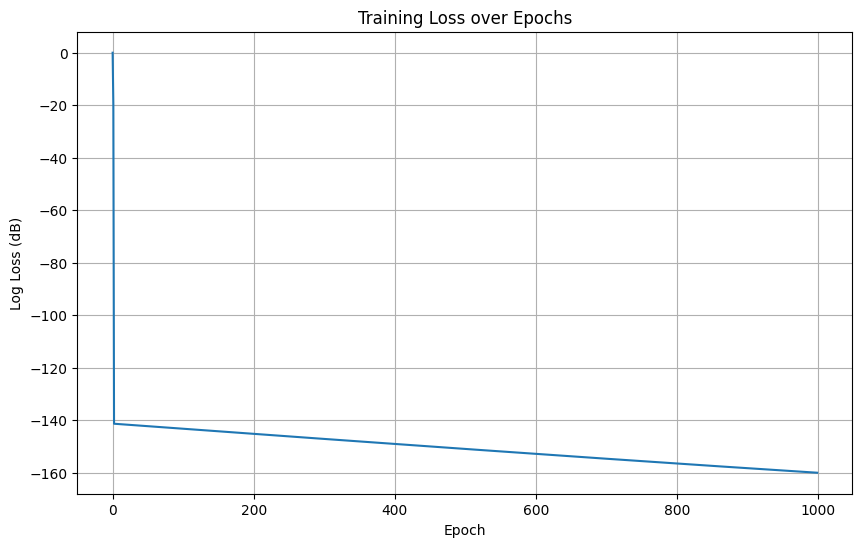

In [163]:
# Loss 시각화
plt.figure(figsize=(10, 6))
plt.plot(10.0 * np.log(losses / (np.max(losses) + 1e-5)))
plt.xlabel('Epoch')
plt.ylabel('Log Loss (dB)')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

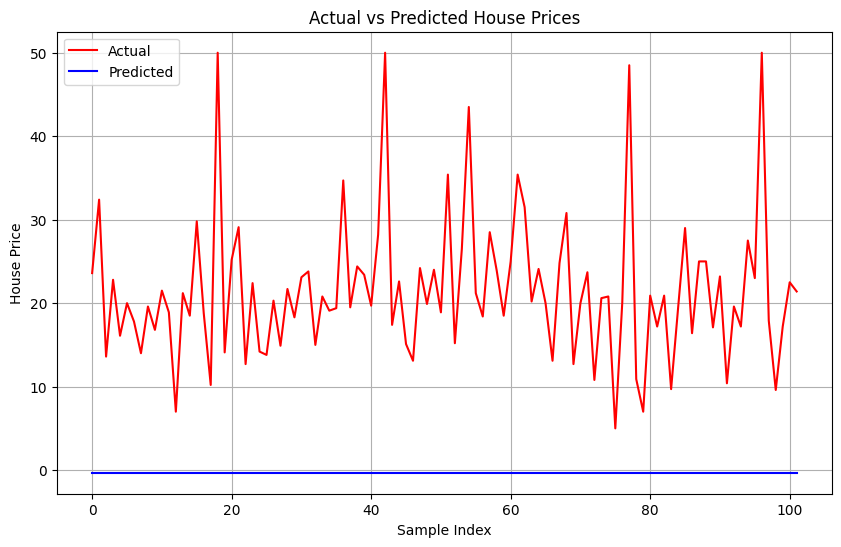

In [162]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, color="red", label="Actual")
plt.plot(y_pred_original, color="blue", label="Predicted")
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.show()